
# Local network

- self-supervised learning on MNIST

- Apply feedback alignment to both layers in the PV class (fc1 and fc2), not just the second one (fc2)? 


In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E943EB88-577E-37A4-93E1-5DAFE97B5744> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Dataset

In [2]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [3]:
from modules.network import LocalNetwork
# from skimage.metrics import structural_similarity as ssim
import numpy as np

lr = 0.001

model = LocalNetwork(input_dim=784, latent_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

print(model)

LocalNetwork(
  (PV): PV(
    (flatten): Flatten()
    (fc1): Linear(in_features=784, out_features=784, bias=True)
    (activation): Sigmoid()
    (fc2): Linear(in_features=784, out_features=128, bias=True)
  )
  (Pyr): Pyr(
    (flatten): Flatten()
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (activation): Sigmoid()
  )
  (Decoder): Decoder(
    (fc1): Linear(in_features=128, out_features=784, bias=True)
  )
)


# Losses: 
- **total_loss** = *lambdaP* * **predict_loss** + **recon_loss**

- **predict_loss** = **ssl_loss** : self-supervised cost of comparison of PV predictions (given input) with Pyr input. PV_Pyr_loss. 
- **predict_loss** = 1/2 (Pyr_out-PV_pred)^2
- **recon_loss** : encourages the model to learn non-trivial representations. Pyr_loss. Used to update Pyr fc1 (input to pyr layer) & decoder weights.
- **recon_loss** = 1/2 (recon-input)^2

# Updating weights:
- ∆ (PV fc2 layer) (i.e PV_Pyr) = lr * grad(total_loss) on (PV fc2 layer) = lr * (Pyr_out -PV_pred)PV_out

- ∆ (PV fc1 layer) = lr * grad(total_loss) on (PV fc1 layer) = lr * grad(total_loss) on (PV_out) * grad(PV_out) on (PV fc1 layer)
- ∆ (Pyr fc1 layer) = lr * grad(total_loss) on (Pyr_out) * grad(Pyr_out) on (Pyr fc1 layer) = lr * (Pyr_out - PV_pred) * input
- Decoder uses recon_loss
- +/- Pyr fc1 uses recon_loss ? 
- Since no L4 equivalent: no need feedback alignement? 




### Training & testing

In [8]:
from modules.utils import calculate_ssim, weight_update, losses


num_epochs = 30
log_interval = 300

train_losses = []
train_pred_losses = []
train_recon_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

def train(epoch, dataloader):
    pred_loss_avg = 0
    recon_loss_avg = 0
    loss_avg = 0
    model.train()
    pred_coeff = 1. 
    for batch_idx, batch in enumerate(dataloader):
        inputs1, _ = batch
        inputs2, _ = batch   
        optimizer.zero_grad()
        PV_out, PV_pred, Pyr_out, recon = model(inputs1, inputs2)  # same inputs for both PV and pyramidal cells

        loss, pred_loss, recon_loss = losses(loss_fn, PV_out, PV_pred, Pyr_out, recon, inputs1, inputs2, pred_coeff)

        weight_update(model, optimizer, loss, recon_loss)
        pred_loss_avg += pred_loss.item()
        recon_loss_avg += recon_loss.item()
        loss_avg += loss.item()

        if batch_idx % log_interval == 0:
            train_losses.append(loss.item())
            train_pred_losses.append(pred_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))

    #pred_loss_avg /= len(dataloader)
    #recon_loss_avg /= len(dataloader)
    #loss_avg /= len(dataloader)
    recon_loss_avg, pred_loss_avg, loss_avg = (loss / len(dataloader) for loss in (recon_loss_avg, pred_loss_avg, loss_avg))
    print('Epoch: {} Pred_loss: {:.6f}  Recon_loss: {:.6f} Total loss: {:.6f}'.format(epoch, pred_loss_avg, recon_loss_avg, loss_avg))

def test(dataloader):
    model.eval()
    pred_loss_avg = 0
    recon_loss_avg = 0
    test_loss_avg = 0
    pred_coeff = 1.
    with torch.no_grad():
        for batch in dataloader:
            inputs1, _ = batch
            inputs2, _ = batch
            PV_out, PV_pred, Pyr_out, recon  = model(inputs1, inputs2)

            loss, pred_loss, recon_loss = losses(loss_fn, PV_out, PV_pred, Pyr_out, recon, inputs1, inputs2, pred_coeff)
            pred_loss_avg += pred_loss.item()
            recon_loss_avg += recon_loss.item()
            test_loss_avg += loss.item()
            #ssim_score = calculate_ssim(recon, inputs)
    #recon_loss_avg /= len(dataloader)        
    #pred_loss_avg /= len(dataloader)
    #test_loss_avg /= len(dataloader)
    recon_loss_avg, pred_loss_avg, test_loss_avg = (loss / len(dataloader) for loss in (recon_loss_avg, pred_loss_avg, test_loss_avg))
    test_losses.append(test_loss_avg)
    print('Test set: Pred_loss: {:.6f}  Recon_loss: {:.6f} Total loss: {:.6f}\n'.format(pred_loss_avg, recon_loss_avg, test_loss_avg))
    


### In practice

In [9]:
test(test_data_loader)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader)
  test(test_data_loader)

Test set: Pred_loss: 0.004511  Recon_loss: 0.087370 Total loss: 0.091881

Epoch: 1 Pred_loss: 0.003599  Recon_loss: 0.079632 Total loss: 0.083231
Test set: Pred_loss: 0.002994  Recon_loss: 0.070948 Total loss: 0.073941

Epoch: 2 Pred_loss: 0.002455  Recon_loss: 0.067654 Total loss: 0.070109
Test set: Pred_loss: 0.002160  Recon_loss: 0.062874 Total loss: 0.065035

Epoch: 3 Pred_loss: 0.001807  Recon_loss: 0.061480 Total loss: 0.063287
Test set: Pred_loss: 0.001708  Recon_loss: 0.058415 Total loss: 0.060123

Epoch: 4 Pred_loss: 0.001398  Recon_loss: 0.058207 Total loss: 0.059604
Test set: Pred_loss: 0.001317  Recon_loss: 0.055919 Total loss: 0.057236

Epoch: 5 Pred_loss: 0.001125  Recon_loss: 0.056232 Total loss: 0.057357
Test set: Pred_loss: 0.001231  Recon_loss: 0.055107 Total loss: 0.056338

Epoch: 6 Pred_loss: 0.000938  Recon_loss: 0.054972 Total loss: 0.055911
Test set: Pred_loss: 0.000943  Recon_loss: 0.054206 Total loss: 0.055149

Epoch: 7 Pred_loss: 0.000803  Recon_loss: 0.053993

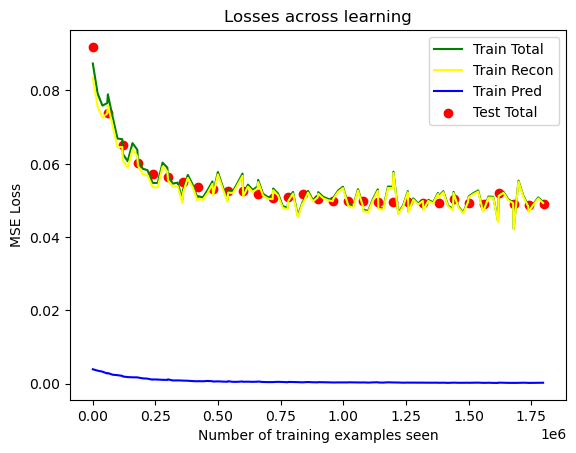

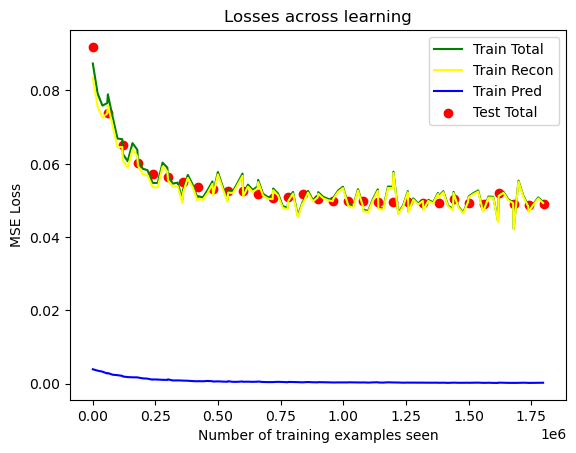

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green')
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_pred_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train Pred', 'Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('MSE Loss')
plt.title("Losses across learning")
fig